# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/federicomercurio/mlfs-book


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [ ]:
today = datetime.datetime.now(datetime.timezone.utc)
tomorrow = today + datetime.timedelta(days = 1)
today

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location_data = json.loads(location_str)

# Parse sensors array
sensors = location_data['sensors']
print(f"Loaded {len(sensors)} sensors")

# Get city and street from first sensor
city = sensors[0]['city']
street = sensors[0]['street']

# Hardcoded coordinates for Milan
latitude = 45.46
longitude = 9.19

2025-11-15 19:33:54,845 INFO: Initializing external client
2025-11-15 19:33:54,846 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 19:33:55,652 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 19:33:56,740 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272011
Loaded 4 sensors


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

# Get all versions of the model
models = mr.get_models("air_quality_xgboost_model")

# Get the latest version (highest version number)
latest_version = max([m.version for m in models])
print(f"Found {len(models)} model versions. Using latest: version {latest_version}")

# Get the latest model (trained with humidity + lag features)
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=latest_version,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Found 8 model versions. Using latest: version 8
2025-11-15 19:34:04,276 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/545096 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/159542 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27851 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.6309208E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [ ]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values('date').reset_index(drop=True)
batch_data

In [ ]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)

# Get PM2.5 predictions for all sensors
all_sensor_forecasts = []

for sensor in sensors:
    # Get the last 3 days of PM2.5 data for this sensor
    three_days_ago = today - datetime.timedelta(days=3)
    historical_pm25 = air_quality_fg.filter(
        (air_quality_fg.date >= three_days_ago) & 
        (air_quality_fg.street == sensor['street'])
    ).read()
    historical_pm25 = historical_pm25.sort_values('date')
    
    print(f"\nSensor: {sensor['street']}")
    
    # Extract lag features
    pm25_values = historical_pm25['pm25'].values
    if len(pm25_values) >= 3:
        pm25_lag1 = pm25_values[-1]
        pm25_lag2 = pm25_values[-2]
        pm25_lag3 = pm25_values[-3]
    elif len(pm25_values) == 2:
        pm25_lag1 = pm25_values[-1]
        pm25_lag2 = pm25_values[-2]
        pm25_lag3 = pm25_values[-2]
    elif len(pm25_values) == 1:
        pm25_lag1 = pm25_values[-1]
        pm25_lag2 = pm25_values[-1]
        pm25_lag3 = pm25_values[-1]
    else:
        pm25_lag1 = pm25_lag2 = pm25_lag3 = 25.0
        print(f"  Warning: No historical data, using default 25.0")
    
    print(f"  Lag features: {pm25_lag1}, {pm25_lag2}, {pm25_lag3}")
    
    # Create forecast data for this sensor
    sensor_forecast = batch_data.copy()
    sensor_forecast['pm25_lag1'] = pm25_lag1
    sensor_forecast['pm25_lag2'] = pm25_lag2
    sensor_forecast['pm25_lag3'] = pm25_lag3
    sensor_forecast['street'] = sensor['street']
    sensor_forecast['country'] = sensor['country']
    sensor_forecast['days_before_forecast_day'] = (
        (pd.to_datetime(sensor_forecast['date']) - pd.to_datetime(today)).dt.days
    )
    
    all_sensor_forecasts.append(sensor_forecast)

# Combine all sensor forecasts
batch_data = pd.concat(all_sensor_forecasts, ignore_index=True)
print(f"\nTotal forecast rows: {len(batch_data)} ({len(sensors)} sensors × {len(batch_data)//len(sensors)} days)")

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 
                'wind_direction_10m_dominant', 'relative_humidity_2m_mean',
                'pm25_lag1', 'pm25_lag2', 'pm25_lag3']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,city,pm25_lag1,pm25_lag2,pm25_lag3,street,country,days_before_forecast_day,predicted_pm25
0,2025-11-20 00:00:00+00:00,7.95,0.0,1.835647,281.309906,58.0,milan,147.000000,30.000000,30.00,lambrate,italy,1,57.764606
1,2025-11-19 00:00:00+00:00,8.10,0.0,0.804985,206.564987,62.0,milan,147.000000,30.000000,30.00,lambrate,italy,2,51.176746
2,2025-11-16 00:00:00+00:00,11.10,3.1,8.766573,70.820900,98.0,milan,147.000000,30.000000,30.00,lambrate,italy,3,54.572357
3,2025-11-17 00:00:00+00:00,13.85,0.0,8.905908,255.963730,78.0,milan,147.000000,30.000000,30.00,lambrate,italy,4,66.310974
4,2025-11-18 00:00:00+00:00,10.10,0.0,2.414953,63.435013,58.0,milan,147.000000,30.000000,30.00,lambrate,italy,5,49.251801
5,2025-11-21 00:00:00+00:00,9.45,0.0,4.452954,284.036255,62.0,milan,147.000000,30.000000,30.00,lambrate,italy,6,60.153530
6,2025-11-20 00:00:00+00:00,7.95,0.0,1.835647,281.309906,58.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,1,40.714233
7,2025-11-19 00:00:00+00:00,8.10,0.0,0.804985,206.564987,62.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,2,44.165848
8,2025-11-16 00:00:00+00:00,11.10,3.1,8.766573,70.820900,98.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,3,46.435532
9,2025-11-17 00:00:00+00:00,13.85,0.0,8.905908,255.963730,78.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,4,43.236134


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         24 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          24 non-null     float32                
 2   precipitation_sum            24 non-null     float32                
 3   wind_speed_10m_max           24 non-null     float32                
 4   wind_direction_10m_dominant  24 non-null     float32                
 5   relative_humidity_2m_mean    24 non-null     float32                
 6   city                         24 non-null     object                 
 7   pm25_lag1                    24 non-null     float32                
 8   pm25_lag2                    24 non-null     float32                
 9   pm25_lag3                    24 non-null     float32                
 10  stre

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
batch_data = batch_data.sort_values(by=['street', 'date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,city,pm25_lag1,pm25_lag2,pm25_lag3,street,country,days_before_forecast_day,predicted_pm25
8,2025-11-16 00:00:00+00:00,11.10,3.1,8.766573,70.820900,98.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,3,46.435532
9,2025-11-17 00:00:00+00:00,13.85,0.0,8.905908,255.963730,78.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,4,43.236134
10,2025-11-18 00:00:00+00:00,10.10,0.0,2.414953,63.435013,58.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,5,42.696640
7,2025-11-19 00:00:00+00:00,8.10,0.0,0.804985,206.564987,62.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,2,44.165848
6,2025-11-20 00:00:00+00:00,7.95,0.0,1.835647,281.309906,58.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,1,40.714233
11,2025-11-21 00:00:00+00:00,9.45,0.0,4.452954,284.036255,62.0,milan,97.559998,52.349998,17.60,Via Cristoforo Gandino,italy,6,42.848694
20,2025-11-16 00:00:00+00:00,11.10,3.1,8.766573,70.820900,98.0,milan,92.099998,47.529999,14.43,Via Dei Lavoratori,italy,3,59.611877
21,2025-11-17 00:00:00+00:00,13.85,0.0,8.905908,255.963730,78.0,milan,92.099998,47.529999,14.43,Via Dei Lavoratori,italy,4,46.187565
22,2025-11-18 00:00:00+00:00,10.10,0.0,2.414953,63.435013,58.0,milan,92.099998,47.529999,14.43,Via Dei Lavoratori,italy,5,43.228142
19,2025-11-19 00:00:00+00:00,8.10,0.0,0.804985,206.564987,62.0,milan,92.099998,47.529999,14.43,Via Dei Lavoratori,italy,2,40.894382


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 8 to 5
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         24 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          24 non-null     float32                
 2   precipitation_sum            24 non-null     float32                
 3   wind_speed_10m_max           24 non-null     float32                
 4   wind_direction_10m_dominant  24 non-null     float32                
 5   relative_humidity_2m_mean    24 non-null     float32                
 6   city                         24 non-null     object                 
 7   pm25_lag1                    24 non-null     float32                
 8   pm25_lag2                    24 non-null     float32                
 9   pm25_lag3                    24 non-null     float32                
 10  street    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-15 19:34:17,908 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



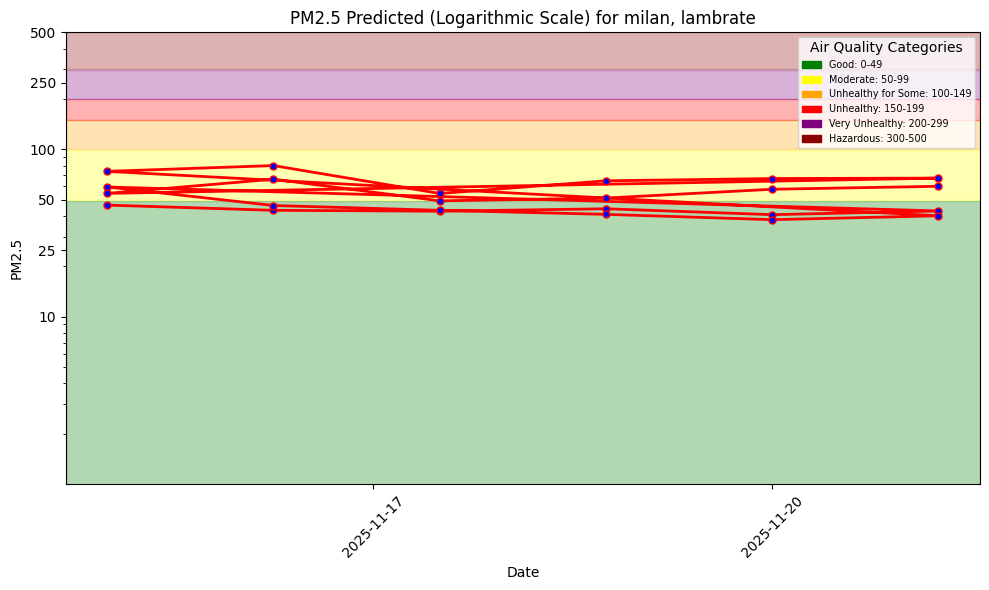

In [13]:
# Use the root_dir that was already defined in the first cell of this notebook
# pred_file_path and hindcast_file_path will be created in the repo root's docs/ directory
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"

# Assicurati che le cartelle esistano
import os
os.makedirs(os.path.dirname(pred_file_path), exist_ok=True)

# Ora puoi chiamare la funzione di util
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
plt.show()

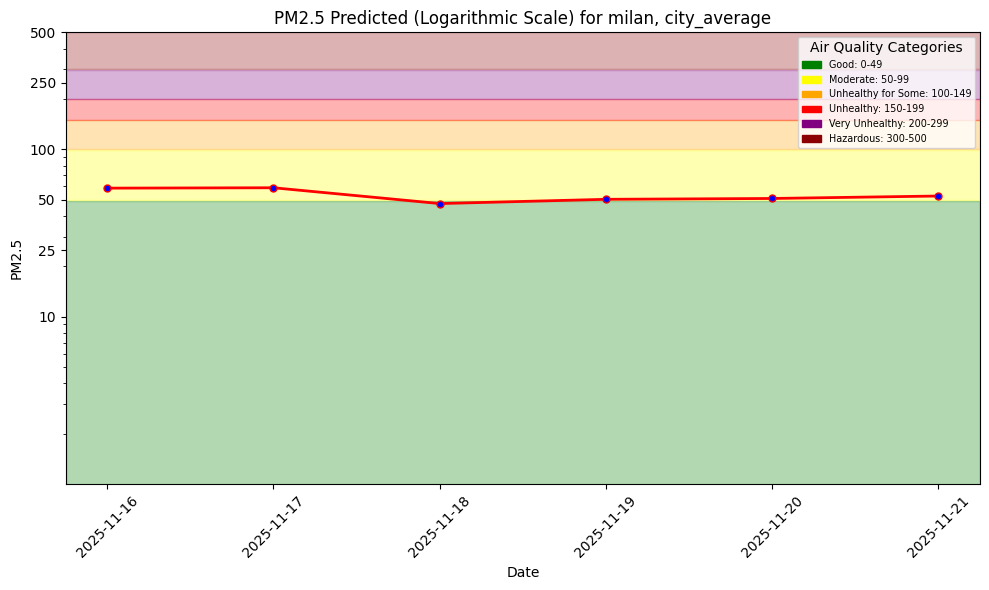

In [14]:
# City average forecast (averaged across all sensors)
city_avg_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_city_avg.png"

# Average predictions across all sensors for each date
city_avg = batch_data.groupby('date').agg({
    'predicted_pm25': 'mean'
}).reset_index()

plt = util.plot_air_quality_forecast(city, 'city_average', city_avg, city_avg_file_path)
plt.show()

In [15]:
# Get or create feature group (version 2 to include humidity and lag features)
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring (with humidity and lag features)',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [16]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 24/24 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272011/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-15 19:34:36,922 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 19:34:40,160 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 19:36:27,442 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 19:36:27,649 INFO: Waiting for log aggregation to finish.
2025-11-15 19:36:46,692 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-20 00:00:00+00:00,7.95,0.0,1.835647,281.309906,58.0,milan,147.000000,30.000000,30.00,57.764606,lambrate,italy,1
1,2025-11-15 00:00:00+00:00,11.40,2.1,6.130579,93.366394,93.0,milan,30.000000,30.000000,30.00,26.668352,lambrate,italy,1
2,2025-11-20 00:00:00+00:00,7.95,0.0,1.835647,281.309906,58.0,milan,97.559998,52.349998,17.60,40.714233,Via Cristoforo Gandino,italy,1
3,2025-11-20 00:00:00+00:00,7.95,0.0,1.835647,281.309906,58.0,milan,92.099998,47.529999,14.43,38.015320,Via Dei Lavoratori,italy,1
4,2025-11-20 00:00:00+00:00,7.95,0.0,1.835647,281.309906,58.0,milan,169.000000,72.900002,26.10,66.934738,Via Federico Chopin,italy,1


In [18]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
# Get weather_fg version 2 for backfill function (if needed)
weather_fg_v2 = fs.get_feature_group(name='weather', version=2)
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.35s) 


,date,pm25,country,city,street,url
0,2021-07-18 00:00:00+00:00,4.90,italy,milan,lambrate,https://api.waqi.info/feed/A156526/
1,2020-09-16 00:00:00+00:00,20.00,italy,milan,lambrate,https://api.waqi.info/feed/milan/
2,2020-05-30 00:00:00+00:00,13.00,italy,milan,lambrate,https://api.waqi.info/feed/milan/
3,2024-10-04 00:00:00+00:00,2.65,italy,milan,lambrate,https://api.waqi.info/feed/A156526/
4,2018-02-18 00:00:00+00:00,50.00,italy,milan,lambrate,https://api.waqi.info/feed/milan/
...,...,...,...,...,...,...
7832,2020-06-03 00:00:00+00:00,3.40,italy,milan,Via Federico Chopin,https://api.waqi.info/feed/A74863/
7833,2020-04-11 00:00:00+00:00,3.78,italy,milan,Via Federico Chopin,https://api.waqi.info/feed/A74863/
7834,2025-01-15 00:00:00+00:00,23.35,italy,milan,Via Cristoforo Gandino,https://api.waqi.info/feed/A196504/
7835,2025-03-09 00:00:00+00:00,30.52,italy,milan,Via Cristoforo Gandino,https://api.waqi.info/feed/A196504/


In [19]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg_v2, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2025-11-15 00:00:00+00:00,26.668352,147.000000
1,2025-11-15 00:00:00+00:00,26.668352,97.559998
2,2025-11-15 00:00:00+00:00,26.668352,92.099998
3,2025-11-15 00:00:00+00:00,26.668352,169.000000


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

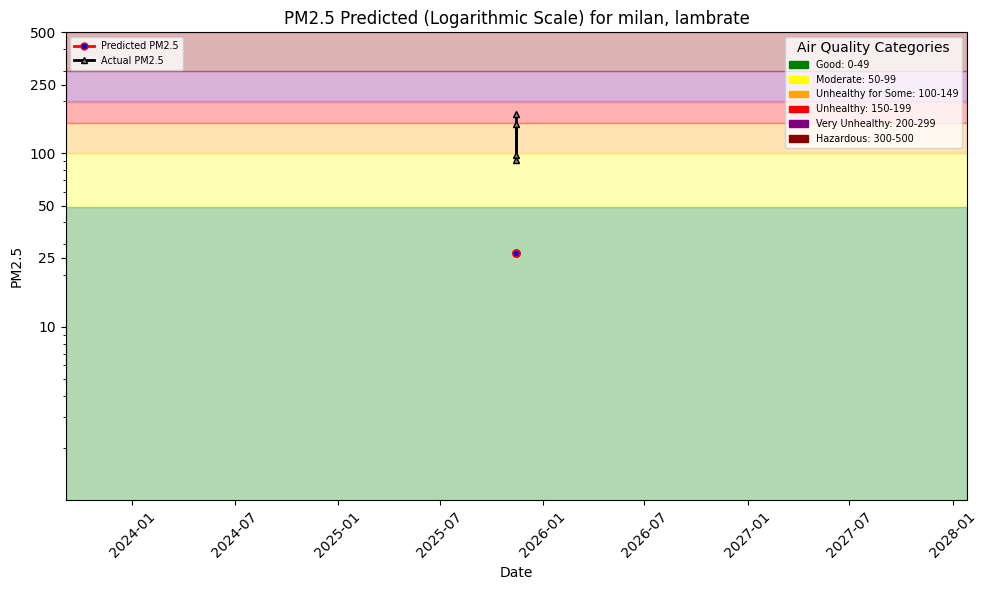

In [20]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [21]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(city_avg_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/federicomercurio/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | …

Uploading /Users/federicomercurio/mlfs-book/docs/air-quality/assets/img/pm25_forecast_city_avg.png: 0.000%|   …

Uploading /Users/federicomercurio/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|       …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272011/settings/fb/path/Resources/airquality


---